## A 250-hPa Hemispheric Map using Python
By: Kevin Goebbert

Date: 24 June 2015

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

The next cell is going to pull in the GFS dataset from the THREDDS server

In [2]:
from datetime import datetime
from siphon.catalog import get_latest_access_url
from siphon.ncss import NCSS

# Latest GFS Dataset
dataset_url = 'http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p5deg/catalog.xml'
ncss = NCSS(get_latest_access_url(dataset_url, 'NetcdfSubset'))

# Set the time to current
now = datetime.utcnow()

# Query for Latest GFS Run
gfsdata = ncss.query().all_times().accept('netcdf4').add_lonlat()
gfsdata.variables('Geopotential_height_isobaric',
                  'u-component_of_wind_isobaric',
                  'v-component_of_wind_isobaric')

# Set the lat/lon box for the data you want to pull in.
# lonlat_box(north_lat, south_lat, east_lon, west_lon)
gfsdata.lonlat_box(0, 360, 0, 90)

# Set desired level 50000 = 50000 Pa = 500 hPa
gfsdata.vertical_level(25000)

# Actually getting the data
data = ncss.get_data(gfsdata)

The next cell will take the downloaded data and parse it to different variables for use later on. Add a cyclic point using the cartopy utility add_cyclic_point to the longitudes (the cyclic dimension) as well as any data that is being contoured or filled.

Smooth the 250-hPa heights using a gaussian filter from scipy.ndimage

Converting times using the num2date function available through netCDF4

In [3]:
from netCDF4 import num2date
import scipy.ndimage as ndimage
import cartopy.util as cutil

dtime = data.variables['Geopotential_height_isobaric'].dimensions[0]
dlat  = data.variables['Geopotential_height_isobaric'].dimensions[2]
dlon  = data.variables['Geopotential_height_isobaric'].dimensions[3]
lat = data.variables[dlat][:]
lon = cutil.add_cyclic_point(data.variables[dlon][:])
times = data.variables[dtime]
vtimes = num2date(times[:], times.units)

hgt_250 = cutil.add_cyclic_point(data.variables['Geopotential_height_isobaric'][:])
Z_250 = ndimage.gaussian_filter(hgt_250, sigma=1.5, order=0)
clev250 = np.arange(9000, 12000, 120)

u250 = cutil.add_cyclic_point(data.variables['u-component_of_wind_isobaric'][:])
v250 = cutil.add_cyclic_point(data.variables['v-component_of_wind_isobaric'][:])
wspd250 = np.sqrt(u250[:10]**2. + v250[:10]**2.) * 1.94384
clevsped250 = np.arange(50, 230, 20)

The next cell sets up the geographic details for the plot that we are going to do later. This is done using the Cartopy package. We will also bring in some geographic data to geo-reference the image for us.

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

crs = ccrs.NorthPolarStereo(central_longitude=-100.0)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='50m',
        facecolor='none')

The next cell transforms our lat/lon projection from Miller to Lambert Conformal

In [5]:
# Make a grid of lat/lon values to use for plotting with Basemap.
clons, clats = np.meshgrid(lon, lat)
tlatslons = crs.transform_points(ccrs.PlateCarree(), clons, clats)
clons = tlatslons[:, :, 0]
clats = tlatslons[:, :, 1]

The next cell is where all of the plotting work takes place, from initializing the figure to limiting the geographic region, adding coastlines and states, with contours of 500 hPa heights.

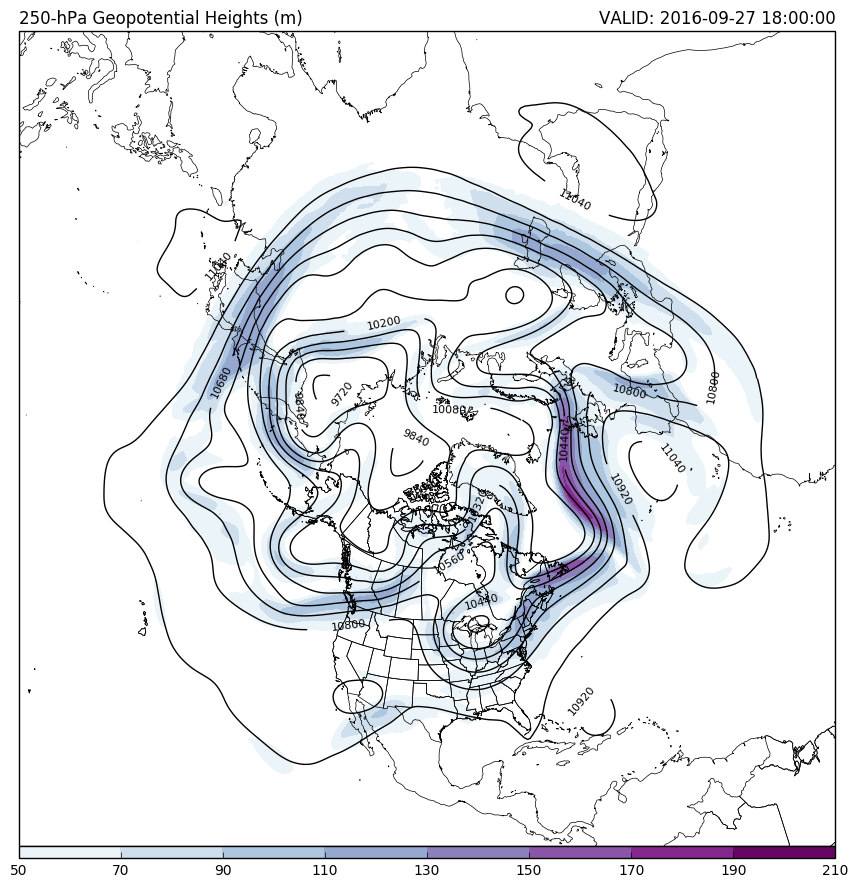

In [6]:
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0

# Set up a figure and axes to draw on using the map projection, complete
# with coastlines and state borders
fig = plt.figure(1, figsize=(17., 12.))
ax = plt.subplot(121, projection=crs)
ax.set_extent([-180, 180, 10, 90], ccrs.PlateCarree())
ax.coastlines('50m', edgecolor='black', linewidth=0.5)
ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)

# Add contours of heights and filled contours of wind speed
cs = ax.contour(clons, clats, Z_250[FH,0,:,:], clev250,
                colors='k', linewidths=1.0, linestyles='solid')
plt.clabel(cs, fontsize=8, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)
cf = ax.contourf(clons, clats, wspd250[FH, 0], clevsped250, cmap='BuPu')
cbar = plt.colorbar(cf, orientation='horizontal', extend='max',
                    pad=0, aspect=65, use_gridspec=True)

ax.set_title('250-hPa Geopotential Heights (m)', loc='left')
ax.set_title('VALID: %s' % vtimes[FH], loc='right')
plt.tight_layout()